In [1]:
# Python Setup
%matplotlib inline
import pandas as pd 
import matplotlib.pyplot as plt  # To visualize
import geopandas as gpd
import shapefile
from shapely.geometry import Point, Polygon

In [2]:
# Read CSV into pandas dataframe
phillyRE_temp = pd.read_csv('/mnt/Ravenclaw/Insight/GettingData/OpenDataPhilly/RTT_SUMMARY_downsampled.csv', index_col=False)
# Drop rows with missing data 
phillyRE_data = phillyRE_temp.dropna()
phillyRE_data.head()

,display_date,street_address,zip_code,document_type,cash_consideration,property_count,lat,lng
2303,2000-05-30,1535 S BROAD ST,19147.0,DEED,1.0,1.0,39.930686,-75.167890
2312,2004-04-02,3083 MEMPHIS ST,19134.0,DEED,58900.0,1.0,39.987205,-75.109769
2315,2004-03-26,1221 HERBERT ST,19124.0,DEED,1.0,1.0,40.020308,-75.088260
2320,2000-05-25,3631 AVALON ST,19114.0,DEED,92000.0,1.0,40.074151,-74.997365
2328,2004-05-28,3430 ALDINE ST,19136.0,DEED,123000.0,1.0,40.038977,-75.041471


In [3]:
# Just checking how many sales were included 
num_gdf = len(phillyRE_data)
print(num_gdf)

1202666


In [4]:
# Get census tract geoData
plt.rcParams['figure.figsize'] = (20, 10)   # Resize map figure, default is really small 
gdf_tracts = gpd.read_file('/mnt/Ravenclaw/Insight/GettingData/Philadelphia_Census_Tracts_2010_201302.geojson')   # Load JSON file
# Rename geoDtaframe columns to match pandas(home)Dataframe columns (not sure if necessary) 
gdf_tracts=gdf_tracts.rename(index=str, columns={"INTPTLAT10":"lat",
                        "INTPTLON10":"lng", "NAMELSAD10":"census_tract"})
gdf_tracts['census_tract'] = gdf_tracts['census_tract'].map(lambda x: x.lstrip('Census Tract ')) # Take out string that says Census Tract
gdf_tracts.head()

,NAME10,AWATER10,TRACTCE10,OBJECTID,GEOID10,ALAND10,STATEFP10,FUNCSTAT10,census_tract,COUNTYFP10,lat,Shape_Leng,LOGRECNO,MTFCC10,lng,geometry
0,50,3340294.0,005000,46.0,42101005000,4504459.0,42,S,50,101,+39.8898768,48033.335048,10389,G5020,-075.1691412,"POLYGON ((-75.17214 39.88129, -75.17505 39.881..."
1,54,530013.0,005400,47.0,42101005400,1846253.0,42,S,54,101,+39.8904539,24624.823144,10390,G5020,-075.2513923,"POLYGON ((-75.24623 39.88951, -75.24799 39.887..."
2,55,12010.0,005500,48.0,42101005500,1168442.0,42,S,55,101,+39.9074191,20389.059940,10391,G5020,-075.2489174,"POLYGON ((-75.25129 39.90440, -75.25297 39.905..."
3,56,0.0,005600,49.0,42101005600,840411.0,42,S,56,101,+39.8988328,11788.147571,10392,G5020,-075.2447347,"POLYGON ((-75.24184 39.90383, -75.24140 39.903..."
4,60,0.0,006000,50.0,42101006000,1089657.0,42,S,60,101,+39.9115196,14205.267812,10393,G5020,-075.2381570,"POLYGON ((-75.23341 39.91384, -75.23273 39.913..."


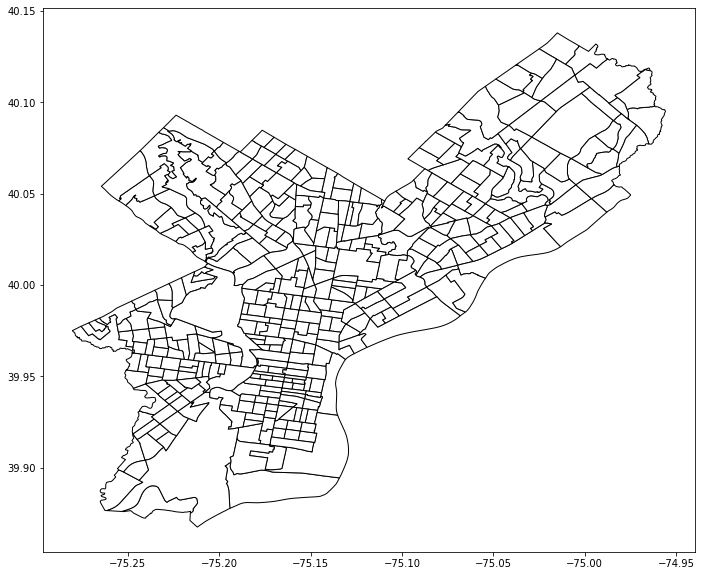

In [5]:
# Show census tract map 
plt.rcParams['figure.figsize'] = (20, 10)   # Resize map figure
ax = gdf_tracts.plot(color='white', edgecolor='black')

In [6]:
# Convert real estate pandas dataframe into geopandas dataframe 
gdf_sales = gpd.GeoDataFrame(phillyRE_data, geometry=gpd.points_from_xy(phillyRE_data.lng, phillyRE_data.lat))
# Make CRS same as geodataframe 
# http://geopandas.org/projections.html
gdf_sales.crs = {'init' :'epsg:4326'}  # standard, used by GPS satellite system 

# Join the real estate and census tract dataframes 
gdf_temp = gpd.sjoin(gdf_sales, gdf_tracts, op='within')

# Convert display_date to date(type)
gdf_temp['display_date'] = gdf_temp['display_date'].astype('datetime64[ns]')

# Create new column (census_year) based on sales date (display_date)
gdf_temp['census_year'] = gdf_temp['display_date'].dt.year
gdf_temp.head()

,display_date,street_address,zip_code,document_type,cash_consideration,property_count,lat_left,lng_left,geometry,index_right,...,STATEFP10,FUNCSTAT10,census_tract,COUNTYFP10,lat_right,Shape_Leng,LOGRECNO,MTFCC10,lng_right,census_year
2303,2000-05-30,1535 S BROAD ST,19147.0,DEED,1.0,1.0,39.930686,-75.167890,POINT (-75.16789 39.93069),215,...,42,S,29,101,+39.9306984,9452.159986,10371,G5020,-075.1655729,2000
2428,2004-05-01,1315 SIGEL ST,19148.0,DEED,63000.0,1.0,39.927174,-75.167653,POINT (-75.16765 39.92717),215,...,42,S,29,101,+39.9306984,9452.159986,10371,G5020,-075.1655729,2004
3380,2004-01-08,1324 MORRIS ST,19148.0,DEED,1.0,1.0,39.928961,-75.167593,POINT (-75.16759 39.92896),215,...,42,S,29,101,+39.9306984,9452.159986,10371,G5020,-075.1655729,2004
5796,2004-05-20,1305 MOORE ST,19148.0,DEED,1.0,1.0,39.927983,-75.167214,POINT (-75.16721 39.92798),215,...,42,S,29,101,+39.9306984,9452.159986,10371,G5020,-075.1655729,2004
7125,2004-04-23,1542 S 12TH ST,19147.0,DEED,1.0,1.0,39.930252,-75.164821,POINT (-75.16482 39.93025),215,...,42,S,29,101,+39.9306984,9452.159986,10371,G5020,-075.1655729,2004


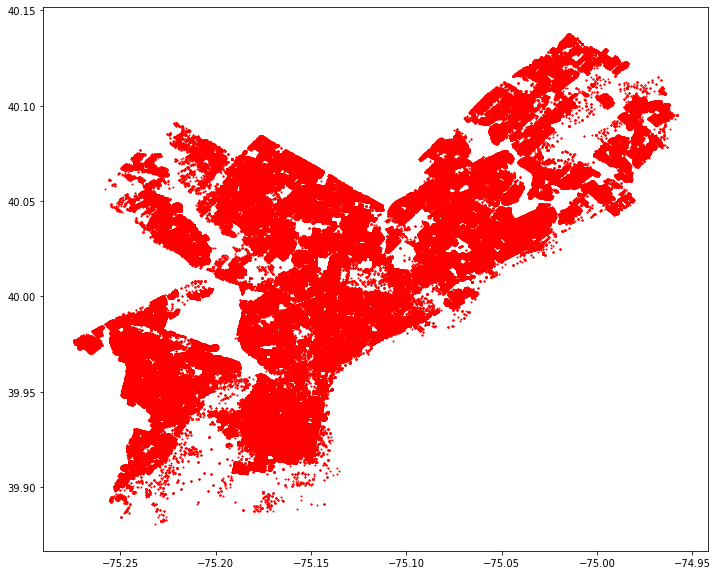

In [7]:
# Plot real estate sales locations  
plt.rcParams['figure.figsize'] = (20, 10)   # Resize map figure, default is really small 
new_ax = gdf_sales.plot(markersize=1, color='red')

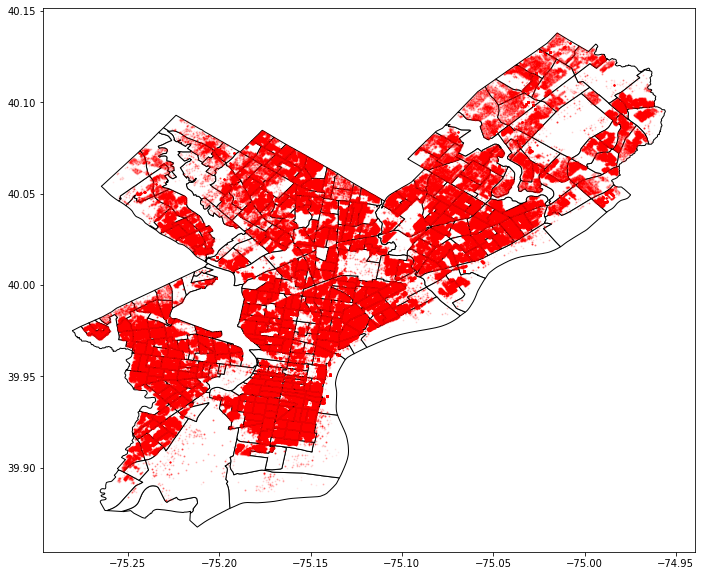

In [8]:
# Plot census tract map and real estate data
plt.rcParams['figure.figsize'] = (20, 10)
base_map = gdf_tracts.plot(color='white', edgecolor='black')
gdf_sales.plot(ax=base_map, markersize=1, color='red', alpha=0.05) #with transparency